In [1]:
# Environment Setup

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', size='14')

import seaborn as sns

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import math
import json
from pprint import pprint
from os import path
import requests

import prepare
import explore

# Acquire

- Create a dataframe from a manually created .CSV file (lower cased column headers and copied and pasted all values from excel) of the activity data. The activity data was acquired during the project requirements phase.

In [2]:
df = pd.read_csv('activity_data.csv')

In [3]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [4]:
df.describe()

,distance,floors,minutes_lightly_active,minutes_fairly_active,minutes_very_active
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,4.046800,12.591111,188.235556,14.920000,33.871111
std,2.506253,25.844174,75.170001,15.363535,37.195986
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.220000,2.000000,158.000000,3.000000,2.000000
50%,3.680000,7.000000,203.000000,11.000000,15.000000
75%,5.900000,13.000000,236.000000,21.000000,63.000000
max,12.000000,195.000000,349.000000,78.000000,154.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB


In [6]:
df.isna().sum()

date                      0
calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

In [7]:
df.isnull().sum()

date                      0
calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

# Prepare

- Explore the data types of the data set

**Note:** numeric values are assigned object types

In [8]:
df.dtypes

date                       object
calories_burned            object
steps                      object
distance                  float64
floors                      int64
minutes_sedentary          object
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories          object
dtype: object

- Create prepare.py file that contains a function which transforms the data in the following ways:


1. Set date to datetime
2. Set date to index
3. Remove commas from several columns
4. Convert data types of non-numeric data types to numeric data types

In [9]:
prep_df = prepare.prep_data(df)

In [10]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
calories_burned           225 non-null int64
steps                     225 non-null int64
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null int64
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


In [11]:
prep_df.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667
std,632.426578,5255.746608,2.506253,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


In [12]:
prep_df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540


# Explore

- First observe at a high level any observations before diving deeper into any characteristics of the owner of the data.

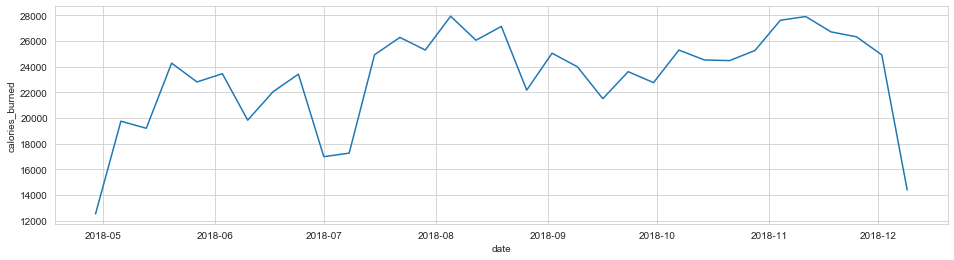

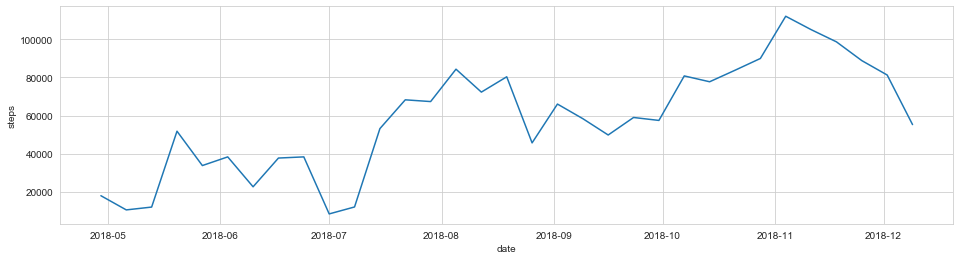

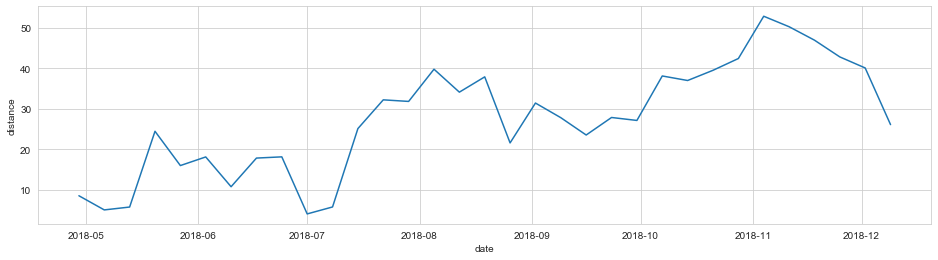

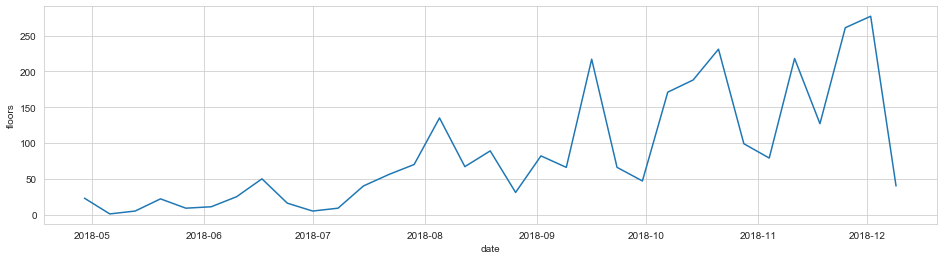

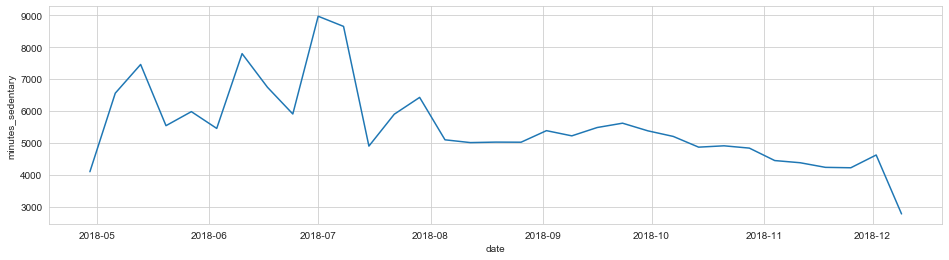

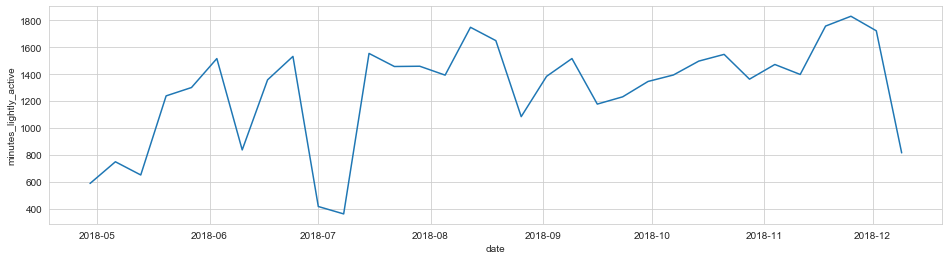

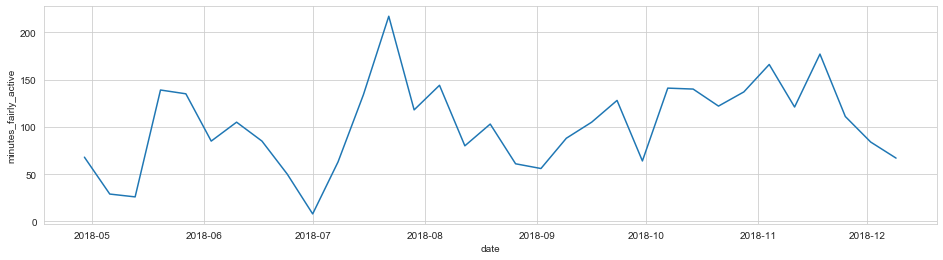

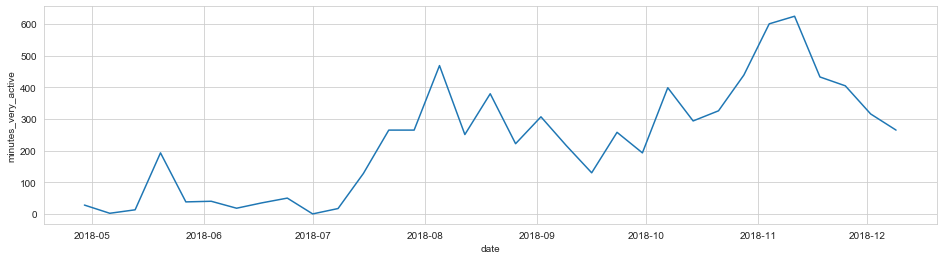

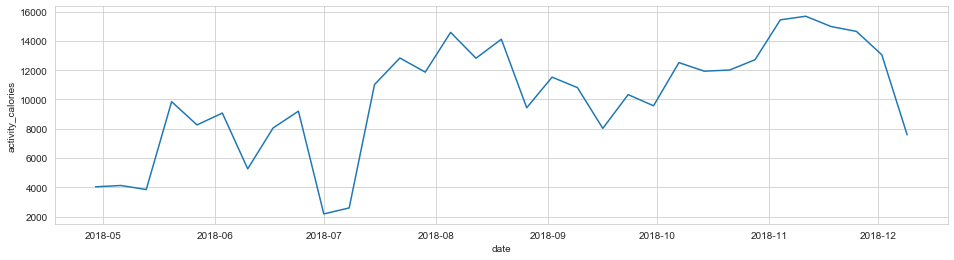

In [13]:
# Resample by week
explore.plot_columns(prep_df)

**Takeaways:** Notice the drastic drop off in November and into December 2018 for nearly all the variables' values when reshaped by week. I'll continue to explore this time period.

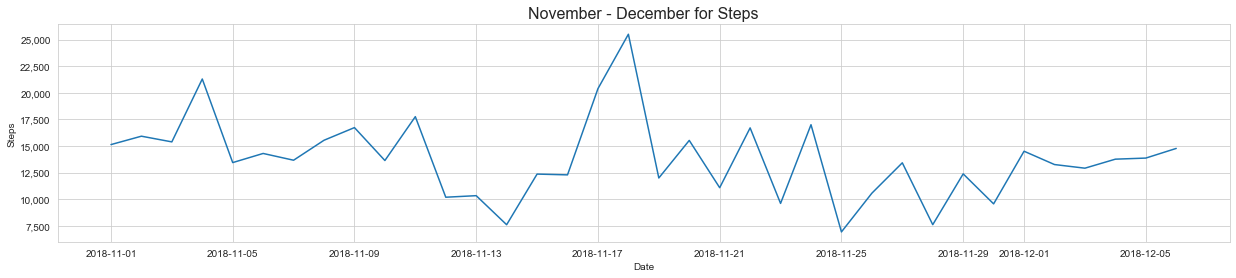

In [14]:
# November - December for steps
plt.figure(figsize = (21,4))
plt.plot(prep_df['steps']['2018-11-01':'2018-12-06'])
plt.xlabel('Date')
plt.ylabel('Steps')
plt.title('November - December for Steps', fontsize = 16)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

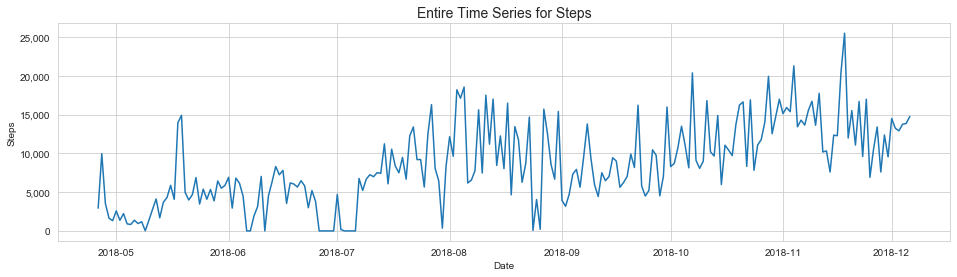

In [15]:
# Entire time series for steps
plt.figure(figsize = (16,4))
plt.plot(prep_df['steps'])
plt.xlabel('Date')
plt.ylabel('Steps')
plt.title('Entire Time Series for Steps', fontsize = 14)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

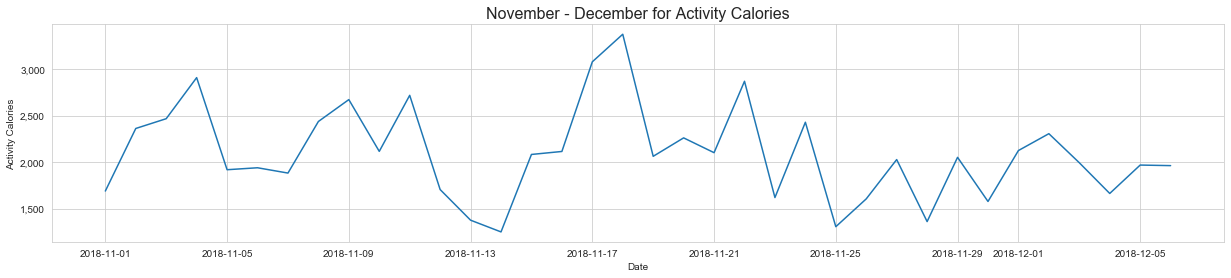

In [16]:
# November - December for activity calories
plt.figure(figsize = (21,4))
plt.plot(prep_df['activity_calories']['2018-11-01':'2018-12-06'])
plt.xlabel('Date')
plt.ylabel('Activity Calories')
plt.title('November - December for Activity Calories', fontsize = 16)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

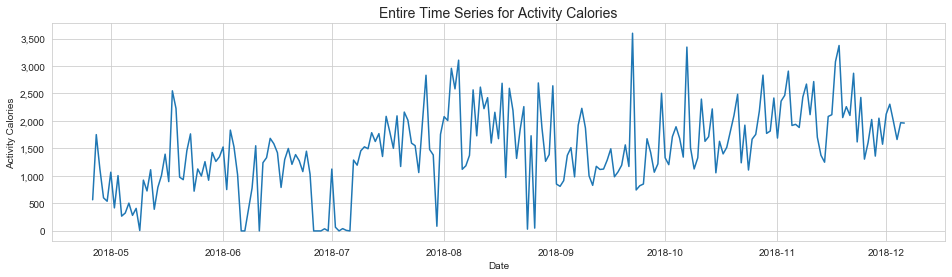

In [17]:
# Entire time series for activity calories
plt.figure(figsize = (16,4))
plt.plot(prep_df['activity_calories'])
plt.xlabel('Date')
plt.ylabel('Activity Calories')
plt.title('Entire Time Series for Activity Calories', fontsize = 14)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

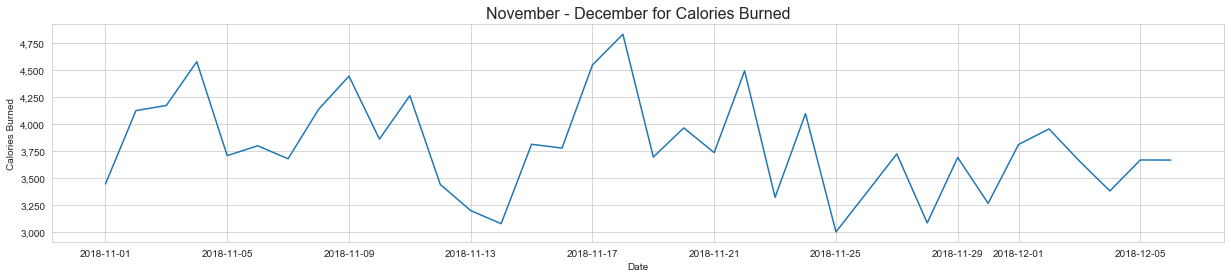

In [18]:
# November - December for calories burned
plt.figure(figsize = (21,4))
plt.plot(prep_df['calories_burned']['2018-11-01':'2018-12-06'])
plt.xlabel('Date')
plt.ylabel('Calories Burned')
plt.title('November - December for Calories Burned', fontsize = 16)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

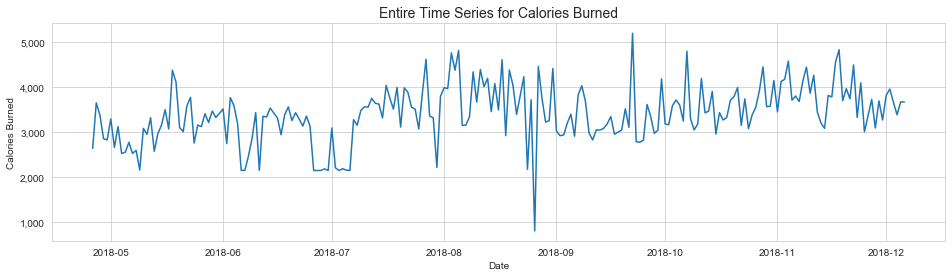

In [19]:
# Entire time series for calories burned
plt.figure(figsize = (16,4))
plt.plot(prep_df['calories_burned'])
plt.xlabel('Date')
plt.ylabel('Calories Burned')
plt.title('Entire Time Series for Calories Burned', fontsize = 14)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Task:** Explore number of steps and the relation to calories

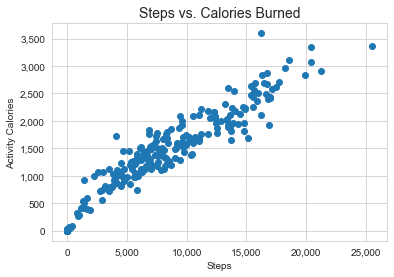

In [20]:
plt.scatter(prep_df['steps'], prep_df['activity_calories'])
plt.title('Steps vs. Calories Burned', fontsize = 14)
plt.xlabel('Steps')
plt.ylabel('Activity Calories')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Task:** Explore distance in float and the relation to calories

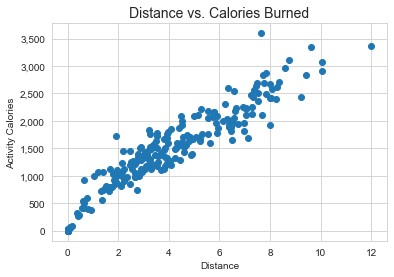

In [21]:
plt.scatter(prep_df['distance'], prep_df['activity_calories'])
plt.title('Distance vs. Calories Burned', fontsize = 14)
plt.xlabel('Distance')
plt.ylabel('Activity Calories')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Takeaways:** Obviously distance and steps are very correlated but figuring out who wore the tracking device is not obvious

In [22]:
prep_df.corr()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
calories_burned,1.000000,0.887355,0.884708,0.263060,-0.572117,0.757374,0.619926,0.789379,0.974944
steps,0.887355,1.000000,0.998907,0.336603,-0.633768,0.644159,0.554991,0.907570,0.941876
distance,0.884708,0.998907,1.000000,0.334290,-0.633868,0.641748,0.549097,0.907409,0.939948
floors,0.263060,0.336603,0.334290,1.000000,-0.225786,0.217456,0.139695,0.346969,0.306165
minutes_sedentary,-0.572117,-0.633768,-0.633868,-0.225786,1.000000,-0.640055,-0.321540,-0.478779,-0.646972
minutes_lightly_active,0.757374,0.644159,0.641748,0.217456,-0.640055,1.000000,0.414857,0.338583,0.780967
minutes_fairly_active,0.619926,0.554991,0.549097,0.139695,-0.321540,0.414857,1.000000,0.448323,0.632311
minutes_very_active,0.789379,0.907570,0.907409,0.346969,-0.478779,0.338583,0.448323,1.000000,0.826950
activity_calories,0.974944,0.941876,0.939948,0.306165,-0.646972,0.780967,0.632311,0.826950,1.000000


### Analysis

- Something stands out from the higher to lower step counts in November. November 18th recorded the highest step count and even during Thanksgiving a high step count is recorded but after the holiday the high counts are not as common.

In [23]:
prep_df.loc['2018-11-18']

calories_burned            4832.0
steps                     25512.0
distance                     12.0
floors                       23.0
minutes_sedentary           450.0
minutes_lightly_active      269.0
minutes_fairly_active        53.0
minutes_very_active         154.0
activity_calories          3373.0
Name: 2018-11-18 00:00:00, dtype: float64

In [24]:
prep_df.loc['2018-11-22']

calories_burned            4494.00
steps                     16705.00
distance                      7.84
floors                      177.00
minutes_sedentary           522.00
minutes_lightly_active      284.00
minutes_fairly_active        18.00
minutes_very_active         115.00
activity_calories          2868.00
Name: 2018-11-22 00:00:00, dtype: float64

# Modeling

### Split data

1. We will use the training proportion method to split.

2. Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)

3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.

4. Return train and test dataframes.

In [25]:
def split_store_data(prep_df, train_prop=.75): 
    train_size = int(len(prep_df) * train_prop)
    train, test = prep_df[0:train_size].reset_index(), prep_df[train_size:len(prep_df)].reset_index()
    return train, test

In [26]:
train, test = split_store_data(prep_df, train_prop=.75)

print('Observations: %d' % (len(prep_df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 168
Testing Observations: 57


In [27]:
target_vars = ['steps']
model_df = prep_df.resample('D')[target_vars].sum()

In [28]:
model_df.head()

,steps
date,
2018-04-26,2931
2018-04-27,9971
2018-04-28,3521
2018-04-29,1639
2018-04-30,1323


- Plot the data first, viewing where the data is split into train and test.

In [29]:
train = train.set_index('date')
test = test.set_index('date')

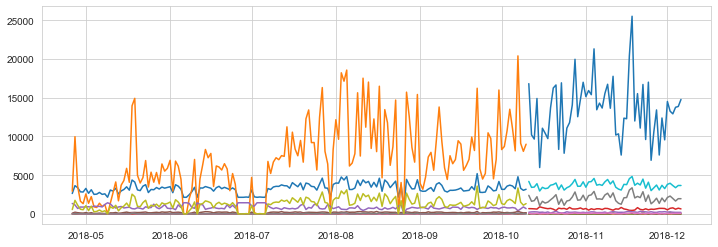

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)

The following functions are for evaluating each of the following different methods for forecasting steps.

The evaluate( ) will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate. There is also a function, plot_and_eval( ) that will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [31]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [32]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()


Create the empty dataframe, eval_df( ) to capture all the evaluation metrics of each of the models we try out. I will also write a function to more efficiently append new metrics to the dataframe.

In [33]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value



Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object.

In [34]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

## Modeling Methods

1. Last Observed Value

2. Simple Average

3. Moving Average

### Last Observed Value

In [35]:
yhat = pd.DataFrame(test.steps)

The following cell finds the last observation for steps and assigns the value as the prediction.

In [36]:
yhat['steps'] = int(train.steps[-1:])


steps -- MSE: 33717262.95 RMSE: 5806.66


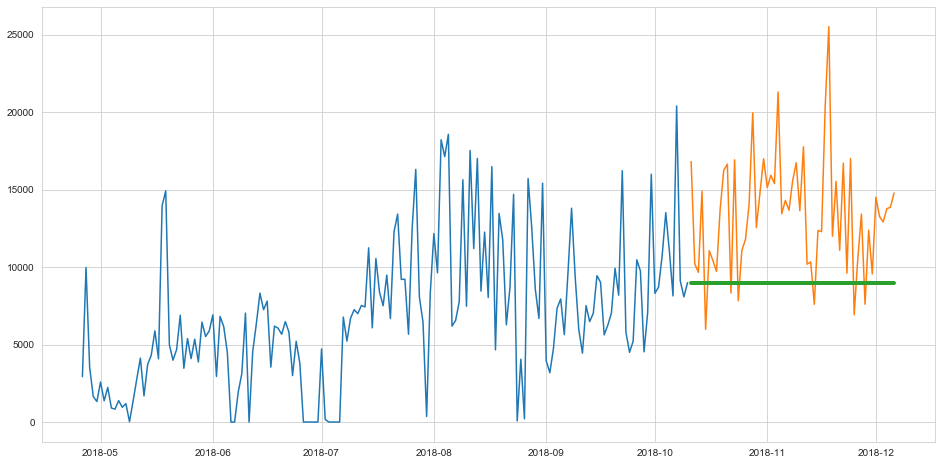

In [37]:
plot_and_eval(target_vars = 'steps', train = train, test = test)


Evaluate using MSE and RMSE, and add evaluation metrics to eval_df( )

In [38]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_vars=['steps'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,3.371726e+07
1,last_observed_value,steps,rmse,5.806657e+03


### Simple Average

Take the simple average of historical values and use that value to predict future values. This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

In [39]:
yhat['steps'] = train.steps.mean()

Now, let's plot and evaluate the performance of our time series model using Simple Average.

steps -- MSE: 57175247.88 RMSE: 7561.43


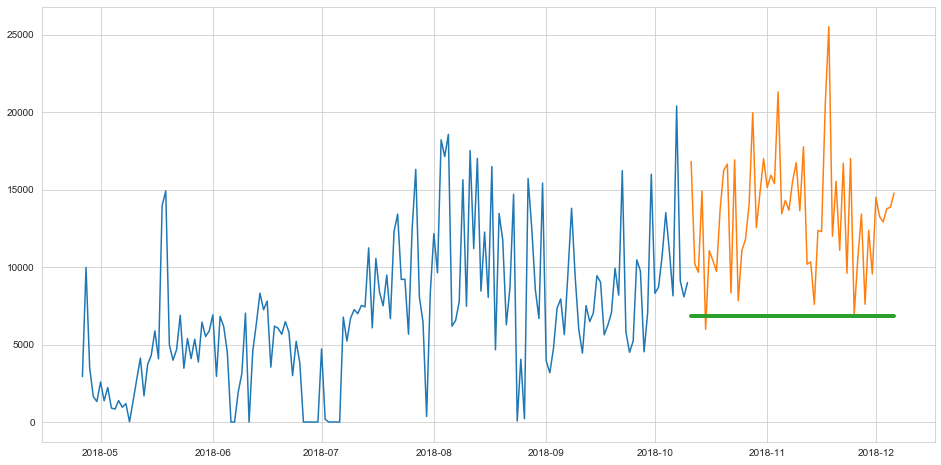

In [40]:
target_vars = ['steps']
plot_and_eval(target_vars, train = train, test = test)

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df( )

In [41]:
eval_df = append_eval_df(model_type='simple_average', target_vars=['steps'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,3.371726e+07
1,last_observed_value,steps,rmse,5.806657e+03
2,simple_average,steps,mse,5.717525e+07
3,simple_average,steps,rmse,7.561432e+03


### Moving Average

In [42]:
periods = 4
yhat['steps'] = train.steps.rolling(periods).mean().iloc[-1]

Now, let's plot and evaluate the performance of our time series model using Moving Average.

steps -- MSE: 17146253.11 RMSE: 4140.80


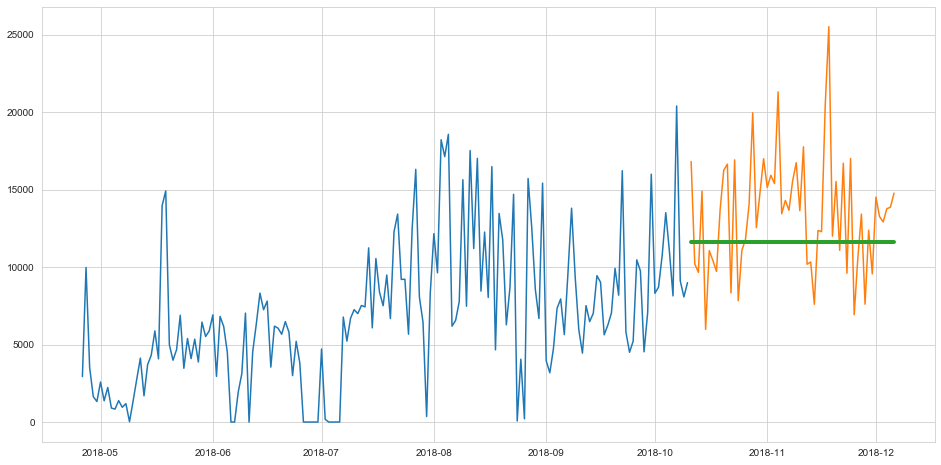

In [43]:
plot_and_eval(target_vars, train = train, test = test)

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df( )

In [44]:
eval_df = append_eval_df(model_type='moving_average_4', target_vars=['steps'], train = train, test = test)
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,3.371726e+07
1,last_observed_value,steps,rmse,5.806657e+03
2,simple_average,steps,mse,5.717525e+07
3,simple_average,steps,rmse,7.561432e+03
4,moving_average_4,steps,mse,1.714625e+07
5,moving_average_4,steps,rmse,4.140803e+03


steps -- MSE: 34443006.28 RMSE: 5868.82


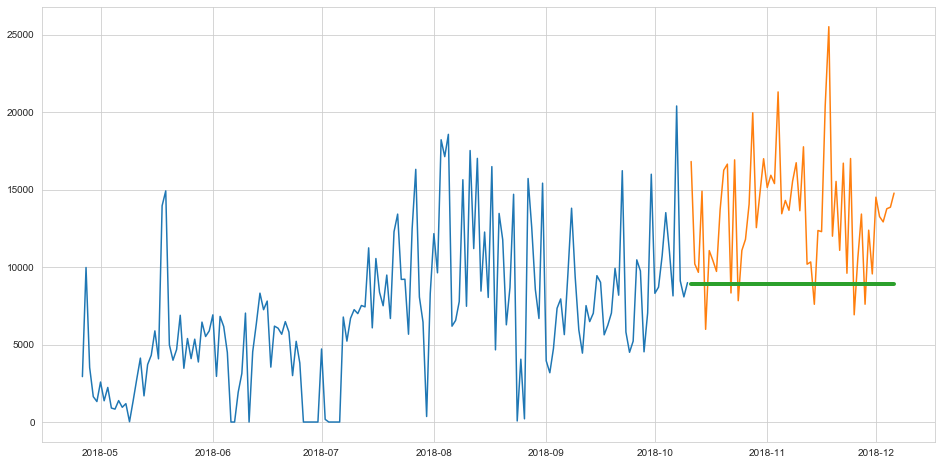


rolling averge period: 1

steps

MSE:  33717262.94736842
RMSE: 5806.656778850324

rolling averge period: 4

steps

MSE:  17146253.10635965
RMSE: 4140.803437300502

rolling averge period: 7

steps

MSE:  18411675.698174007
RMSE: 4290.88285766158

rolling averge period: 14

steps

MSE:  23754913.40359828
RMSE: 4873.90125090756

rolling averge period: 30

steps

MSE:  34443006.28368421
RMSE: 5868.816429543883

rolling averge period: 60

steps

MSE:  34401019.88678362
RMSE: 5865.238263428318

rolling averge period: 90

steps

MSE:  30727055.178583495
RMSE: 5543.199002253436


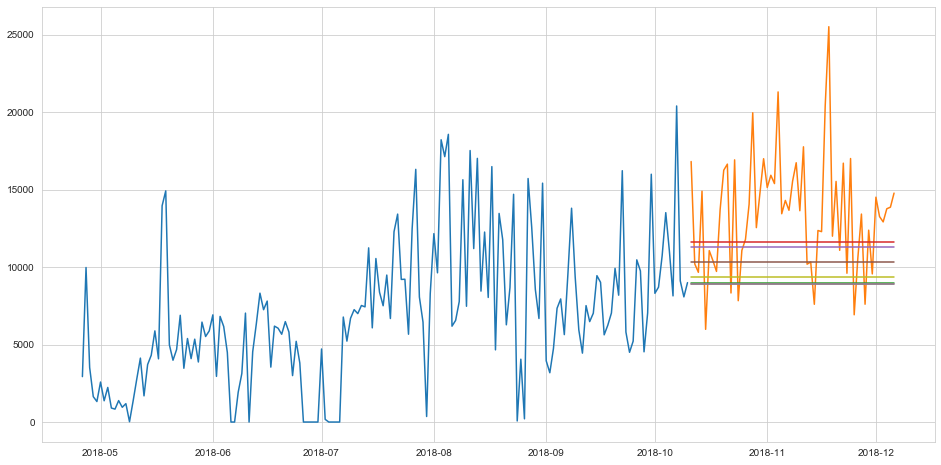

In [45]:
periods = 30
yhat['steps'] = train.steps.rolling(periods).mean().iloc[-1]

plot_and_eval(target_vars, train, test)
#eval_df = append_eval_df(model_type='moving_average', target_vars=['steps'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 7, 14, 30, 60, 90]
for p in period_vals:
    yhat['steps'] = train.steps.rolling(p).mean().iloc[-1]
    plt.plot(yhat.steps)
    print('\nrolling averge period:',p)
    print('\nsteps\n')
    evaluate('steps', train = train, test = test)

**Takeaways:** of the different number of periods within the Moving Average method the 4 period moving average performed the best for predicting the number of steps.

In [46]:
eval_df

,model_type,target_var,metric,value
0,last_observed_value,steps,mse,3.371726e+07
1,last_observed_value,steps,rmse,5.806657e+03
2,simple_average,steps,mse,5.717525e+07
3,simple_average,steps,rmse,7.561432e+03
4,moving_average_4,steps,mse,1.714625e+07
5,moving_average_4,steps,rmse,4.140803e+03


### Analysis

- After evaluating all the different modeling methods the 4 period moving average performed the best for predicting the number of steps.

## Predict

- Predictions for the missing two weeks worth of data in a separate csv file.

In [47]:
predict_df = pd.read_csv('activity_data.csv')

In [48]:
predict_df.tail()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
220,12/2/18,"3,957","13,257",6.23,195,725,265,13,70,"2,305"
221,12/3/18,"3,660","12,915",6.12,6,782,219,40,51,"1,993"
222,12/4/18,"3,384","13,763",6.49,13,608,199,11,67,"1,663"
223,12/5/18,"3,670","13,865",6.52,12,739,200,12,69,"1,968"
224,12/6/18,"3,669","14,774",6.96,9,647,198,4,78,"1,962"


In [49]:
predict_df = prepare.prep_data(predict_df)

In [50]:
predict_df.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663
2018-12-05,3670,13865,6.52,12,739,200,12,69,1968
2018-12-06,3669,14774,6.96,9,647,198,4,78,1962


In [51]:
pred = pd.DataFrame()
dates = pd.DataFrame({"date": ['12/7/2018','12/8/2018','12/9/2018',\
                               '12/10/2018','12/11/2018','12/12/2018',\
                               '12/13/2018','12/14/2018','12/15/2018',\
                               '12/16/2018','12/17/2018','12/18/2018',\
                               '12/19/2018','12/20/2018']})
pred = pred.append(dates)

In [52]:
pred.tail()

,date
9,12/16/2018
10,12/17/2018
11,12/18/2018
12,12/19/2018
13,12/20/2018


In [53]:
pred.set_index('date', inplace=True)

In [54]:
pred['calories_burned'] = round(train['calories_burned'].rolling(4).mean().iloc[-1],0)
pred['steps'] = round(train['steps'].rolling(4).mean().iloc[-1],0)
pred['distance'] = round(train['distance'].rolling(4).mean().iloc[-1],2)
pred['floors'] = round(train['floors'].rolling(4).mean().iloc[-1],0)
pred['minutes_sedentary'] = round(train['minutes_sedentary'].rolling(4).mean().iloc[-1],0)
pred['minutes_lightly_active'] = round(train['minutes_lightly_active'].rolling(4).mean().iloc[-1],0)
pred['minutes_fairly_active'] = round(train['minutes_fairly_active'].rolling(4).mean().iloc[-1],0)
pred['minutes_very_active'] = round(train['minutes_very_active'].rolling(4).mean().iloc[-1],0)
pred['activity_calories'] = round(train['activity_calories'].rolling(4).mean().iloc[-1],0)

In [55]:
pred

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
12/7/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/8/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/9/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/10/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/11/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/12/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/13/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/14/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0
12/15/2018,3582.0,11645.0,5.49,43.0,658.0,205.0,34.0,51.0,1828.0


In [56]:
pred.to_csv('2_weeks_predictions.csv')

# Conclusions

The final analysis concludes that the user, over time, became more active. Also, the month of November is very interesting because of the high steps counts recorded. There was a sudden drop in steps count also in November and into December.  I found that to be interesting and will mention those findings in my final presentation slides.  

In order to predict future values for each variable I used various modeling methods, compared their metrics, and selected the best performer.  Finally a .CSV file was created containg the predicted values for the following two weeks of data missing.


